Enter initial cwnd (e.g., 1):  1
Enter initial ssthresh (e.g., 8):  16
Enter total number of packets (e.g., 50):  80
Enter packet loss probability (0 to 1):  0



=== TCP Reno Simulation ===

Initial cwnd: 1
Initial ssthresh: 16
Packet loss probability: 0.0
Total packets to send: 80


RTT 1 | State: Slow Start | cwnd: 1 | ssthresh: 16
  - Packet 1 sent successfully

RTT 2 | State: Slow Start | cwnd: 2 | ssthresh: 16
  - Packet 2 sent successfully
  - Packet 3 sent successfully

RTT 3 | State: Slow Start | cwnd: 4 | ssthresh: 16
  - Packet 4 sent successfully
  - Packet 5 sent successfully
  - Packet 6 sent successfully
  - Packet 7 sent successfully

RTT 4 | State: Slow Start | cwnd: 8 | ssthresh: 16
  - Packet 8 sent successfully
  - Packet 9 sent successfully
  - Packet 10 sent successfully
  - Packet 11 sent successfully
  - Packet 12 sent successfully
  - Packet 13 sent successfully
  - Packet 14 sent successfully
  - Packet 15 sent successfully

RTT 5 | State: Congestion Avoidance | cwnd: 16 | ssthresh: 16
  - Packet 16 sent successfully
  - Packet 17 sent successfully
  - Packet 18 sent successfully
  - Packet 19 sent successfully
  - Pac

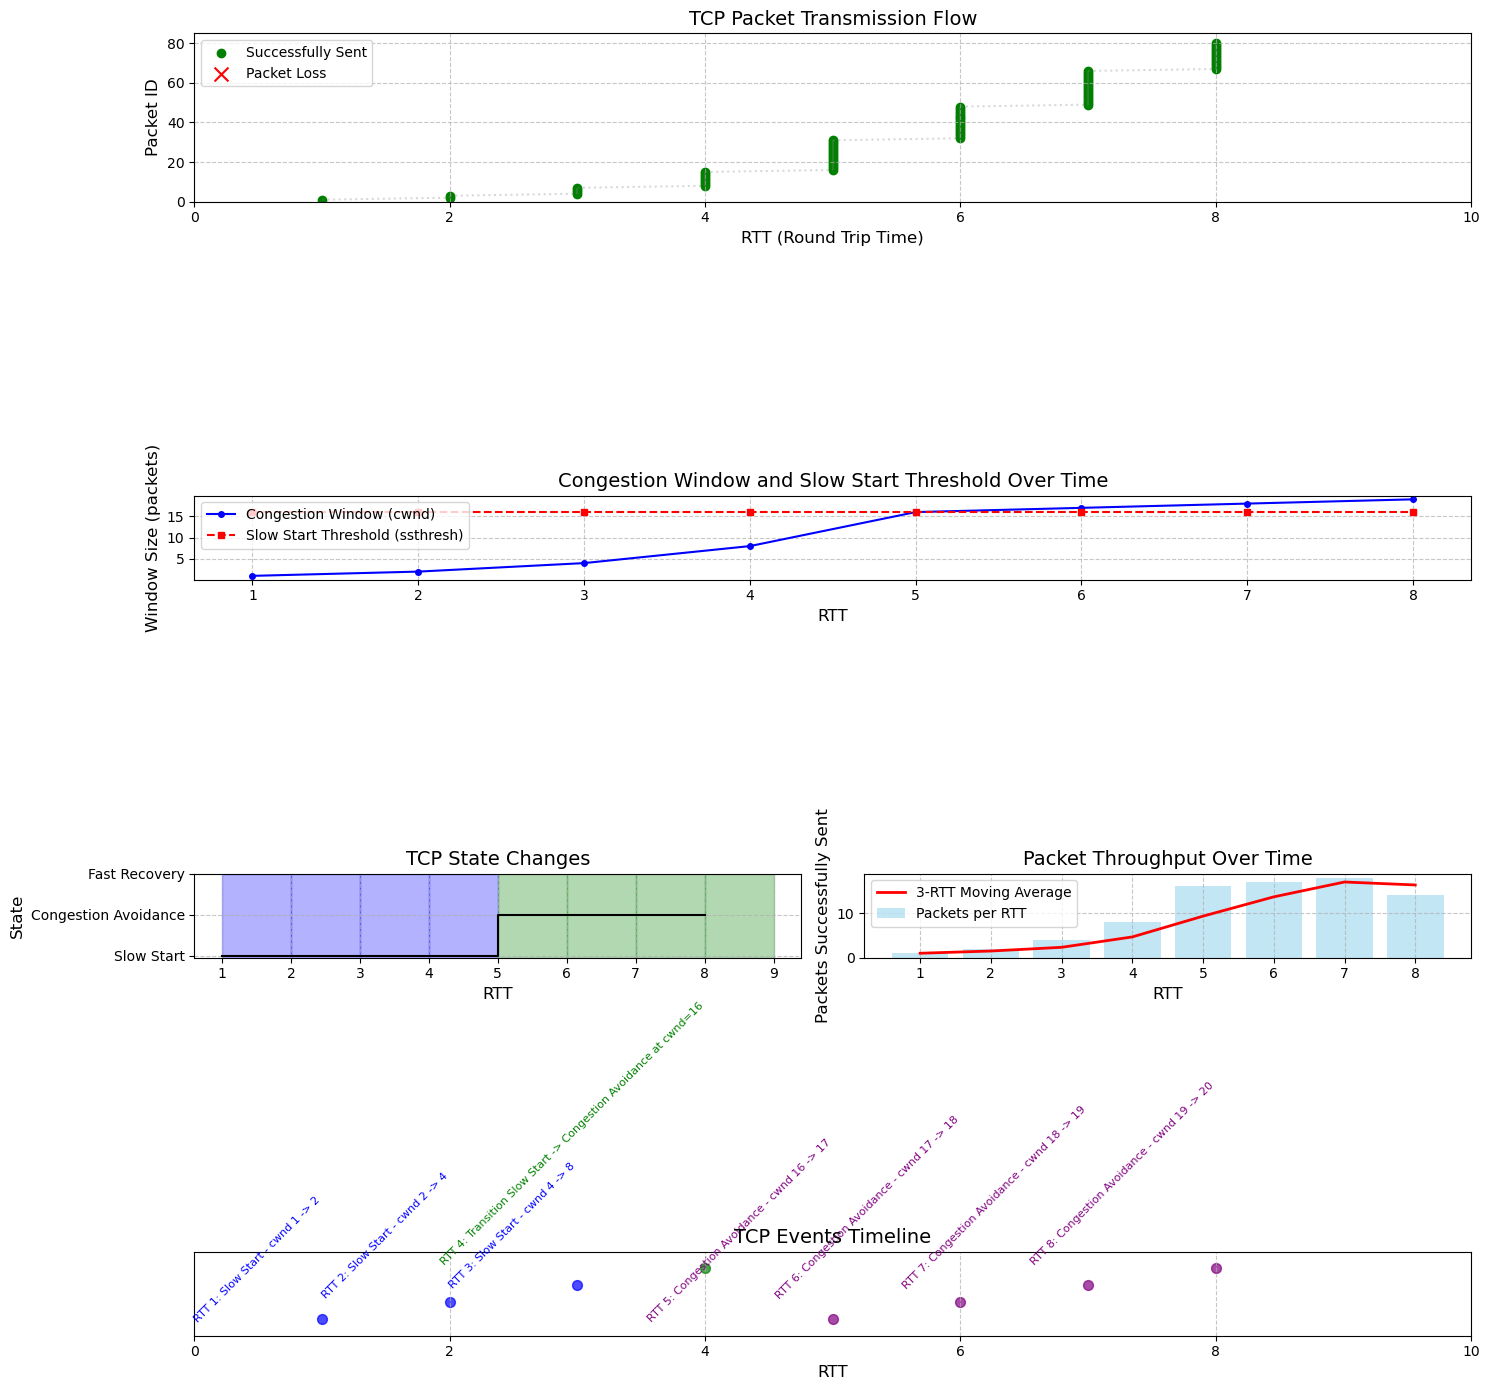

/var/folders/fg/vdt0_pqd3sj5711grsyg63tw0000gn/T/ipykernel_45326/1782684351.py:328: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  loss_dots, = ax.plot([], [], 'ro', marker='x', markersize=10, label='Packet Loss')


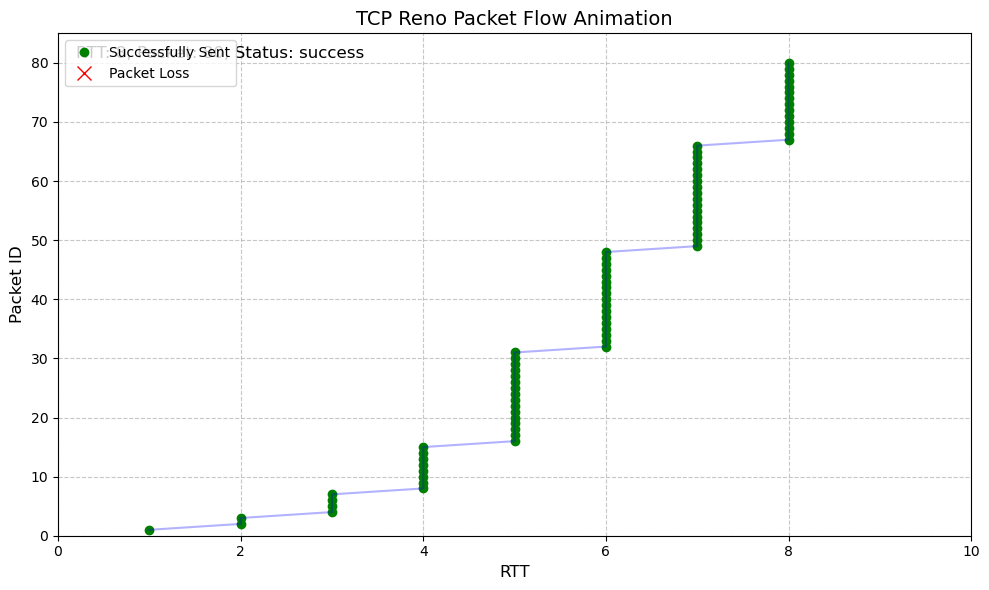

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import numpy as np
from IPython.display import HTML
from matplotlib.gridspec import GridSpec

def run_tcp_simulation():
    # Input Parameters
    initial_cwnd = int(input("Enter initial cwnd (e.g., 1): "))
    ssthresh = int(input("Enter initial ssthresh (e.g., 8): "))
    total_packets = int(input("Enter total number of packets (e.g., 50): "))
    packet_loss_chance = float(input("Enter packet loss probability (0 to 1): "))
    
    # Initialize Variables
    cwnd = initial_cwnd
    packets_sent = 0
    rtt = 0
    state = "Slow Start"
    dup_ack_count = 0
    last_ack_packet = -1
    fast_recovery = False
    timeout_occurred = False
    
    # History for plotting
    cwnd_history = []
    state_history = []
    ssthresh_history = []
    packet_flow = []  # (rtt, packet_id, status)
    packet_events = []  # For detailed logs
    
    # Congestion Control Simulation
    print("\n=== TCP Reno Simulation ===\n")
    print(f"Initial cwnd: {initial_cwnd}")
    print(f"Initial ssthresh: {ssthresh}")
    print(f"Packet loss probability: {packet_loss_chance}")
    print(f"Total packets to send: {total_packets}\n")
    
    while packets_sent < total_packets:
        rtt += 1
        loss_occurred = False
        rtt_packets = []
        
        # Log current state
        print(f"\nRTT {rtt} | State: {state} | cwnd: {cwnd} | ssthresh: {ssthresh}")
        
        # Send packets in this RTT up to cwnd
        packets_in_this_rtt = 0
        for i in range(int(cwnd)):  # Using int() to handle fractional cwnd during congestion avoidance
            if packets_sent >= total_packets:
                break
                
            packet_id = packets_sent + 1
            packets_in_this_rtt += 1
            
            # Simulate packet loss
            if random.random() < packet_loss_chance and not loss_occurred:
                print(f"  - Packet {packet_id} LOST")
                rtt_packets.append((rtt, packet_id, 'loss'))
                packet_events.append(f"RTT {rtt}: Packet {packet_id} lost")
                loss_occurred = True
                
                # Determine if it's a timeout or will be handled by fast recovery
                if random.random() < 0.3:  # 30% chance of timeout vs triple duplicate ACK
                    timeout_occurred = True
                    packet_events.append(f"RTT {rtt}: Timeout detected")
                else:
                    dup_ack_count = 3  # Simulate receiving 3 duplicate ACKs
                    last_ack_packet = packet_id
                    packet_events.append(f"RTT {rtt}: Triple duplicate ACKs detected")
                
                break
            else:
                print(f"  - Packet {packet_id} sent successfully")
                rtt_packets.append((rtt, packet_id, 'success'))
                packets_sent += 1
        
        packet_flow.extend(rtt_packets)
        cwnd_history.append(cwnd)
        state_history.append(state)
        ssthresh_history.append(ssthresh)
        
        # Handle congestion control
        if loss_occurred:
            if timeout_occurred:
                # Timeout handling
                print("TIMEOUT: Reducing cwnd to 1 and ssthresh to half")
                ssthresh = max(cwnd // 2, 2)
                cwnd = 1
                state = "Slow Start"
                timeout_occurred = False
                packet_events.append(f"RTT {rtt}: TIMEOUT - cwnd reset to 1, ssthresh={ssthresh}")
            elif dup_ack_count >= 3:
                # Fast Recovery handling
                print("FAST RECOVERY: Reducing ssthresh and adjusting cwnd")
                ssthresh = max(cwnd // 2, 2)
                cwnd = ssthresh + 3
                fast_recovery = True
                state = "Fast Recovery"
                packet_events.append(f"RTT {rtt}: FAST RECOVERY - ssthresh={ssthresh}, cwnd={cwnd}")
        elif fast_recovery:
            # Exiting Fast Recovery
            print("Exiting FAST RECOVERY: Setting cwnd to ssthresh")
            cwnd = ssthresh
            fast_recovery = False
            state = "Congestion Avoidance"
            dup_ack_count = 0
            packet_events.append(f"RTT {rtt}: Exit Fast Recovery - cwnd={cwnd}")
        else:
            # Normal operation - either Slow Start or Congestion Avoidance
            if state == "Slow Start":
                old_cwnd = cwnd
                cwnd = min(cwnd * 2, ssthresh)
                
                # Check if we're transitioning to Congestion Avoidance
                if cwnd == ssthresh:
                    state = "Congestion Avoidance"
                    packet_events.append(f"RTT {rtt}: Transition Slow Start -> Congestion Avoidance at cwnd={cwnd}")
                else:
                    packet_events.append(f"RTT {rtt}: Slow Start - cwnd {old_cwnd} -> {cwnd}")
            
            elif state == "Congestion Avoidance":
                old_cwnd = cwnd
                cwnd += 1  
                packet_events.append(f"RTT {rtt}: Congestion Avoidance - cwnd {old_cwnd} -> {cwnd}")
    
  
    print("\n=== Simulation Complete ===")
    print(f"Total RTTs: {rtt}")
    print(f"Packets sent: {packets_sent}")
    
 
    create_visualizations(packet_flow, cwnd_history, state_history, ssthresh_history, packet_events, total_packets, rtt)
    
    return packet_flow, cwnd_history, state_history, ssthresh_history, packet_events

def create_visualizations(packet_flow, cwnd_history, state_history, ssthresh_history, packet_events, total_packets, max_rtt):
    # Create a figure with multiple subplots
    plt.figure(figsize=(15, 14))
    
    # Setup GridSpec for better layout control
    gs = GridSpec(4, 2, height_ratios=[2, 1, 1, 1])
    
    # 1. Packet Flow Visualization (Static)
    ax1 = plt.subplot(gs[0, :])
    plot_packet_flow_static(ax1, packet_flow, max_rtt, total_packets)
    
    # 2. CWND and SSTHRESH over time
    ax2 = plt.subplot(gs[1, :])
    plot_cwnd_ssthresh(ax2, cwnd_history, ssthresh_history)
    
    # 3. State Changes
    ax3 = plt.subplot(gs[2, 0])
    plot_state_changes(ax3, state_history)
    
    # 4. Packet Throughput
    ax4 = plt.subplot(gs[2, 1])
    plot_throughput(ax4, packet_flow, max_rtt)
    
    # 5. Events timeline
    ax5 = plt.subplot(gs[3, :])
    plot_events_timeline(ax5, packet_events, max_rtt)
    
    plt.tight_layout()
    plt.show()
    
    # Create the animation
    create_packet_flow_animation(packet_flow, max_rtt, total_packets)

def plot_packet_flow_static(ax, packet_flow, max_rtt, total_packets):
    success_rtts = [rtt for rtt, packet_id, status in packet_flow if status == 'success']
    success_packets = [packet_id for rtt, packet_id, status in packet_flow if status == 'success']
    loss_rtts = [rtt for rtt, packet_id, status in packet_flow if status == 'loss']
    loss_packets = [packet_id for rtt, packet_id, status in packet_flow if status == 'loss']
    
    ax.scatter(success_rtts, success_packets, color='green', marker='o', label='Successfully Sent')
    ax.scatter(loss_rtts, loss_packets, color='red', marker='x', s=100, label='Packet Loss')
    
    # Connect packets with lines to show flow
    last_rtt = 0
    last_packet = 0
    for rtt, packet_id, status in packet_flow:
        if last_rtt > 0:
            ax.plot([last_rtt, rtt], [last_packet, packet_id], 'gray', alpha=0.3, linestyle=':')
        last_rtt = rtt
        last_packet = packet_id
    
    ax.set_xlim(0, max_rtt + 2)
    ax.set_ylim(0, total_packets + 5)
    ax.set_title("TCP Packet Transmission Flow", fontsize=14)
    ax.set_xlabel("RTT (Round Trip Time)", fontsize=12)
    ax.set_ylabel("Packet ID", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper left')

def plot_cwnd_ssthresh(ax, cwnd_history, ssthresh_history):
    rtts = list(range(1, len(cwnd_history) + 1))
    
    ax.plot(rtts, cwnd_history, 'b-', marker='o', markersize=4, label='Congestion Window (cwnd)')
    ax.plot(rtts, ssthresh_history, 'r--', marker='s', markersize=4, label='Slow Start Threshold (ssthresh)')
    
    for i in range(1, len(cwnd_history)):
        if cwnd_history[i] < cwnd_history[i-1]:
            ax.axvline(x=i+1, color='orange', linestyle='--', alpha=0.5)
            ax.annotate('Congestion', xy=(i+1, cwnd_history[i]), xytext=(i+1, cwnd_history[i]+1),
                       arrowprops=dict(facecolor='orange', shrink=0.05), fontsize=8)
    
    ax.set_title("Congestion Window and Slow Start Threshold Over Time", fontsize=14)
    ax.set_xlabel("RTT", fontsize=12)
    ax.set_ylabel("Window Size (packets)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper left')

def plot_state_changes(ax, state_history):
    rtts = list(range(1, len(state_history) + 1))
    
    state_values = []
    for state in state_history:
        if state == "Slow Start":
            state_values.append(1)
        elif state == "Congestion Avoidance":
            state_values.append(2)
        elif state == "Fast Recovery":
            state_values.append(3)
        else:
            state_values.append(0)
    
    colors = ['blue', 'green', 'red']
    states = ["Slow Start", "Congestion Avoidance", "Fast Recovery"]
    
    ax.step(rtts, state_values, where='post', color='black')
    
    for i, state_value in enumerate(state_values):
        if i < len(state_values) - 1:
            ax.axvspan(rtts[i], rtts[i+1], alpha=0.3, color=colors[state_value-1])
        else:
            ax.axvspan(rtts[i], rtts[i]+1, alpha=0.3, color=colors[state_value-1])
    
    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels(states)
    
    ax.set_title("TCP State Changes", fontsize=14)
    ax.set_xlabel("RTT", fontsize=12)
    ax.set_ylabel("State", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

def plot_throughput(ax, packet_flow, max_rtt):
    throughput = {}
    for rtt, packet_id, status in packet_flow:
        if status == 'success':
            throughput[rtt] = throughput.get(rtt, 0) + 1
    
    rtts = list(range(1, max_rtt + 1))
    packets_per_rtt = [throughput.get(rtt, 0) for rtt in rtts]
    
    # Calculating moving average for smoothing
    window_size = 3
    moving_avg = []
    for i in range(len(packets_per_rtt)):
        if i < window_size - 1:
            moving_avg.append(sum(packets_per_rtt[:i+1]) / (i+1))
        else:
            moving_avg.append(sum(packets_per_rtt[i-window_size+1:i+1]) / window_size)
    
    ax.bar(rtts, packets_per_rtt, alpha=0.5, color='skyblue', label='Packets per RTT')
    ax.plot(rtts, moving_avg, 'r-', linewidth=2, label=f'{window_size}-RTT Moving Average')
    
    ax.set_title("Packet Throughput Over Time", fontsize=14)
    ax.set_xlabel("RTT", fontsize=12)
    ax.set_ylabel("Packets Successfully Sent", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper left')

def plot_events_timeline(ax, packet_events, max_rtt):
    y_pos = 0
    event_types = {
        'TIMEOUT': 'red',
        'FAST RECOVERY': 'orange',
        'Transition': 'green',
        'Slow Start': 'blue',
        'Congestion Avoidance': 'purple',
        'lost': 'red',
        'Exit': 'magenta'
    }
    
    for event in packet_events:
        # Extract RTT from event string
        rtt = int(event.split(':')[0].replace('RTT ', ''))
        
        # Determine color based on event type
        color = 'gray'  # default
        for event_type, event_color in event_types.items():
            if event_type in event:
                color = event_color
                break
        
        # Plot event as a colored point
        ax.scatter(rtt, y_pos, color=color, alpha=0.7, s=50)
        
        # Add event text with rotation for better readability
        if y_pos % 2 == 0:
            ax.annotate(event, xy=(rtt, y_pos), xytext=(rtt, y_pos-0.2), 
                      rotation=45, ha='right', fontsize=8, color=color)
        else:
            ax.annotate(event, xy=(rtt, y_pos), xytext=(rtt, y_pos+0.2), 
                      rotation=45, ha='right', fontsize=8, color=color)
        
        y_pos = (y_pos + 1) % 4  # Cycle through 4 positions to avoid overlap
    
    ax.set_title("TCP Events Timeline", fontsize=14)
    ax.set_xlabel("RTT", fontsize=12)
    ax.set_yticks([])  # Hide y-axis ticks
    ax.set_xlim(0, max_rtt + 2)
    ax.set_ylim(-1, 4)
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

def create_packet_flow_animation(packet_flow, max_rtt, total_packets):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, max_rtt + 2)
    ax.set_ylim(0, total_packets + 5)
    ax.set_title("TCP Reno Packet Flow Animation", fontsize=14)
    ax.set_xlabel("RTT", fontsize=12)
    ax.set_ylabel("Packet ID", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Plot objects for animation
    success_dots, = ax.plot([], [], 'go', label='Successfully Sent')
    loss_dots, = ax.plot([], [], 'ro', marker='x', markersize=10, label='Packet Loss')
    flow_line, = ax.plot([], [], 'b-', alpha=0.3)
    status_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12)
    
    x_success, y_success = [], []
    x_loss, y_loss = [], []
    x_flow, y_flow = [], []
    
    def init():
        success_dots.set_data([], [])
        loss_dots.set_data([], [])
        flow_line.set_data([], [])
        status_text.set_text('')
        return success_dots, loss_dots, flow_line, status_text
    
    def animate(i):
        frame = min(i, len(packet_flow)-1)  
        
        current_packets = packet_flow[:frame+1]
        
        # Reset data for redraw
        x_success.clear()
        y_success.clear()
        x_loss.clear()
        y_loss.clear()
        x_flow.clear()
        y_flow.clear()
      
        for rtt, packet_id, status in current_packets:
            if status == 'success':
                x_success.append(rtt)
                y_success.append(packet_id)
            else:
                x_loss.append(rtt)
                y_loss.append(packet_id)
          
            x_flow.append(rtt)
            y_flow.append(packet_id)
        
        success_dots.set_data(x_success, y_success)
        loss_dots.set_data(x_loss, y_loss)
        flow_line.set_data(x_flow, y_flow)
        
        if frame < len(packet_flow):
            rtt, packet_id, status = packet_flow[frame]
            status_text.set_text(f"RTT: {rtt}, Packet: {packet_id}, Status: {status}")
        
        return success_dots, loss_dots, flow_line, status_text
    
    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=len(packet_flow)+10, interval=200, blit=True)
    
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    return HTML(ani.to_jshtml())

if __name__ == "__main__":
    run_tcp_simulation()